In [25]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

In [26]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4129, 67)
(4129,)
(1030, 67)
(1030,)


In [28]:
def xgboost_classification(X_train, y_train, X_test, y_test, params):
    """
    Perform XGBoost multiclass classification, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """

    warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")
    
    # Create a label encoder
    label_encoder = LabelEncoder()
    
    # Encode the class labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Inverse transform for class labels in the confusion matrix
    class_labels = label_encoder.classes_
    
    # Create a DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest = xgb.DMatrix(X_test)

    num_round = 100  # Number of boosting rounds

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_round)

   # Predict labels
    y_pred_prob = model.predict(dtest)
    print("Shape of y_pred_prob:", y_pred_prob.shape)
    y_pred_class = np.argmax(y_pred_prob, axis=1)  # Find the index of the maximum probability for each sample
    y_pred = [class_labels[idx] for idx in y_pred_class]  # Convert indices to class labels

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    

Shape of y_pred_prob: (1030, 5)


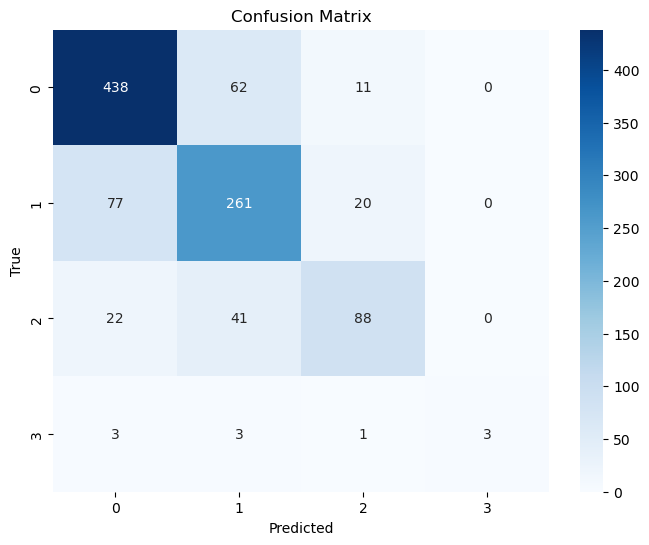

Matthews Correlation Coefficient: 0.6120531866879594
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       511
           1       0.71      0.73      0.72       358
           2       0.73      0.58      0.65       151
           3       1.00      0.30      0.46        10

    accuracy                           0.77      1030
   macro avg       0.81      0.62      0.67      1030
weighted avg       0.77      0.77      0.76      1030



In [29]:
# Define parameters for the XGBoost model
base_params = {
    'objective': 'multi:softprob',  # Multiclass classification
    'num_class': 5,  # Number of classes
    'max_depth': 6,  # Maximum depth of trees
    'eta': 0.3,  # Learning rate
}

# Call the xgboost_classification function with your data
xgboost_classification(X_train, y_train, X_test, y_test, base_params)

In [36]:
import optuna
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def objective(trial, X_train, y_train, X_test, y_test):
    # Create a label encoder
    label_encoder = LabelEncoder()
    
    # Encode the class labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Inverse transform for class labels in the confusion matrix
    class_labels = label_encoder.classes_
    
    # Create a DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest = xgb.DMatrix(X_test)

    params = {
        'objective': 'multi:softprob',
        'num_class': 5,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'lambda': trial.suggest_int('lambda', 0, 100),
        'alpha': trial.suggest_int('alpha', 0, 100),
    }

    num_round = 100

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_round)

    # Predict labels
    y_pred_prob = model.predict(dtest)
    y_pred_class = np.argmax(y_pred_prob, axis=1)  # Find the index of the maximum probability for each sample
    y_pred = [class_labels[idx] for idx in y_pred_class]  # Convert indices to class labels

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)

    return mcc

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

additional_params = {
    'objective': 'multi:softprob',
    'num_class': 5,
}

# Get the best parameters
best_params = study.best_params.copy()
best_params.update(additional_params)
print("Best Parameters:", best_params)


[I 2023-11-11 18:28:24,500] A new study created in memory with name: no-name-6e210c03-3cf6-4eb4-a19a-5b56632b25f5
[I 2023-11-11 18:28:25,001] Trial 0 finished with value: 0.37600921310602003 and parameters: {'max_depth': 9, 'eta': 0.4931055006872001, 'subsample': 0.9911888646253546, 'lambda': 42, 'alpha': 47}. Best is trial 0 with value: 0.37600921310602003.
[I 2023-11-11 18:28:25,918] Trial 1 finished with value: 0.5074768853807946 and parameters: {'max_depth': 7, 'eta': 0.6457753519761401, 'subsample': 0.7369291024000135, 'lambda': 56, 'alpha': 16}. Best is trial 1 with value: 0.5074768853807946.
[I 2023-11-11 18:28:26,373] Trial 2 finished with value: 0.3735463083011183 and parameters: {'max_depth': 3, 'eta': 0.2921128963326603, 'subsample': 0.5230002664860054, 'lambda': 61, 'alpha': 16}. Best is trial 1 with value: 0.5074768853807946.
[I 2023-11-11 18:28:27,084] Trial 3 finished with value: 0.5211988282648553 and parameters: {'max_depth': 4, 'eta': 0.769550053340303, 'subsample': 0

Best Parameters: {'max_depth': 10, 'eta': 0.8924892377828996, 'subsample': 0.6829920590408511, 'lambda': 95, 'alpha': 0, 'objective': 'multi:softprob', 'num_class': 5}


Shape of y_pred_prob: (1030, 5)


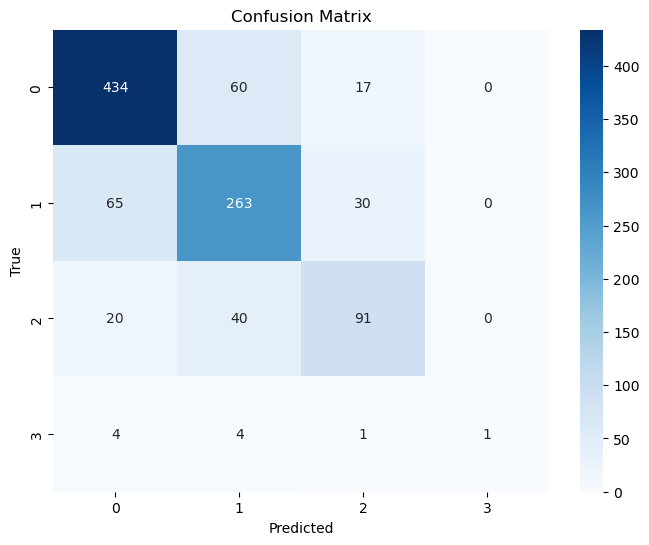

Matthews Correlation Coefficient: 0.6131630277535396
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       511
           1       0.72      0.73      0.73       358
           2       0.65      0.60      0.63       151
           3       1.00      0.10      0.18        10

    accuracy                           0.77      1030
   macro avg       0.80      0.57      0.59      1030
weighted avg       0.77      0.77      0.76      1030



In [37]:
xgboost_classification(X_train, y_train, X_test, y_test, best_params)